In [61]:
from google.colab import drive
drive.mount('/content/drive')
stt3795 = "drive/MyDrive/STT3795"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import numpy as np
import pandas as pd
import scipy
import nltk
import matplotlib.pyplot as plt
import matplotlib as mpl
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

import sklearn as sk
from collections import defaultdict, Counter
import seaborn as sns
import spacy
from spacy import displacy

import pickle

# Télécharger les ressources nécessaires pour NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Mettre la définition des graphiques assez haute pour le rapport
mpl.rcParams['figure.dpi'] = 400

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [63]:
def extract_data_msr(filepath):
    df = pd.read_csv(filepath, delimiter="\t+", header=None)[1:]

    # Re-index from 0
    df.index = np.arange(0, len(df))

    # Extract data
    labels = df[0].to_list()
    tags = df[1].to_list()
    tags.extend(df[2].to_list())
    data = df[3].to_list()
    data.extend(df[4].to_list())
    return labels, tags, data

def extract_data_qqp(filepath, size=62500):
    df = pd.read_csv(filepath, delimiter="\t+", header=None)[1:]

    # Re-index from 0
    df.index = np.arange(0, len(df))

    # Extract data
    labels = df[5].to_list()[:size]
    tags = df[1].to_list()[:size]
    tags.extend(df[2].to_list()[:size])
    data = df[3].to_list()[:size]
    data.extend(df[4].to_list()[:size])
    return labels, tags, data

def prep_data(data_train, data_test, do_tokenize=True):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tmp_data_train = data_train.copy()

    # Prepare training data
    for i in range(len(tmp_data_train)):
        # Standardize text
        tmp_data_train[i] = tmp_data_train[i].strip().lower()

        # Tokenize
        tokens = word_tokenize(tmp_data_train[i])

        # Lemmatize (trunkate words)
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Remove stop words
        tokens = list(filter(lambda token: token not in stop_words, tokens))

        # Update data
        if do_tokenize:
            tmp_data_train[i] = tokens
        else:
            tmp_data_train[i] = " ".join(tokens)

    # Prepare test data
    if do_tokenize:
        data_test = [word_tokenize(x.strip().lower()) for x in data_test]
    else:
        data_test = [x.strip().lower() for x in data_test]

    return tmp_data_train, data_test


# Dataset

QQP:
*   Train : 363 845
*   Test  : 390 962
*   Dev   : 40 429

[id, qid1, qid2, question1, question2, is_duplicate]

STS-B:
*   Train : 5 748
*   Test  : 1 378
*   Dev   : 1 499

[index, genre, filename, year, old_index, source1, source2, sentence1, sentence2, score]

MRPC:
*   Train : 4 076
*   Test  : 1 725
*   Dev   : -

[Quality, #1 ID, #2 ID, #1 String, #2 String]

Peut-être pas exactement les bons chiffres



In [75]:
stop_words = set(stopwords.words('english'))

labels_train, tags_train, data_train = extract_data_msr(f"{stt3795}/MRPC/msr_paraphrase_train.txt")
labels_test, tags_test, data_test = extract_data_msr(f"{stt3795}/MRPC/msr_paraphrase_test.txt")
# labels_train, tags_train, data_train = extract_data_qqp(f"{stt3795}/QQP/train.tsv")
# labels_test, tags_test, data_test = extract_data_qqp(f"{stt3795}/QQP/dev.tsv")
print("Train data shape:", np.array(data_train).shape)
print("Test data shape:", np.array(data_test).shape)


Train data shape: (8152,)
Test data shape: (3450,)


In [76]:
# data_train, data_test = prep_data(data_train, data_test, do_tokenize=False)
data_train, data_test = pd.Series(data_train), pd.Series(data_test)


# Analyse simple
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools


In [66]:
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [73]:
def print_stats(title, data):
  print(f"-----{title}-----")
  print(f"Mean: {np.mean(data)}")
  print(f"STD: {np.std(data)}")
  print(f"Median: {np.median(data)}")
  print(f"Range: {np.ptp(data)}")
  print(f"IQR: {scipy.stats.iqr(data)}")
  print(f"Kurtosis: {scipy.stats.kurtosis(data)}")


# Longueur par phrase
def length_of_sentences(dataset_similaire, dataset_assimilaire, dataset):
  data_sim = dataset_similaire.str.len()
  data_assim = dataset_assimilaire.str.len()
  data = dataset.str.len()
  print(data.max())
  data.hist(range=(0,250), color="#00FF0040")  # range pour éviter les valeurs aberrantes
  data_sim.hist(range=(0,250), color="#FF000040")
  data_assim.hist(range=(0,250), color="#0000FF40")
  plt.title("Fréquence de la longueur des phrases")
  plt.xlabel("Longueur")
  plt.ylabel("Fréquence")
  plt.grid(False)
  plt.legend(["Toutes phrases", "Phrases similaires", "Phrases non similaires"])
  plt.show()
  print_stats("similaires", data_sim)
  print_stats("non similaires", data_assim)
  print_stats("global", data)

# Longueur par mots
def length_of_words(dataset_similaire, dataset_assimilaire, dataset):
    data_sim = dataset_similaire.str.split().map(lambda x: len(x))
    data_assim = dataset_assimilaire.str.split().map(lambda x: len(x))
    data = dataset.str.split().map(lambda x: len(x))
    data.hist(range=(0,50), color="#00FF0040")  # range pour éviter les valeurs aberrantes
    data_sim.hist(range=(0,50), color="#FF000040")
    data_assim.hist(range=(0,50), color="#0000FF40")
    plt.title("Fréquence de la longueur des mots")
    plt.xlabel("Longueur")
    plt.ylabel("Fréquence")
    plt.grid(False)
    plt.legend(["Toutes phrases", "Phrases similaires", "Phrases non similaires"])
    plt.show()
    print_stats("similaires", data_sim)
    print_stats("non similaires", data_assim)
    print_stats("global", data)

# Longueur moyenne des mots par phrase
def mean_length_of_words(dataset_similaire, dataset_assimilaire, dataset):
    data_sim = dataset_similaire.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    data_assim = dataset_assimilaire.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    data = dataset.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    data.hist(range=(0,15), color="#00FF0040")  # range pour éviter les valeurs aberrantes
    data_sim.hist(range=(0,15), color="#FF000040")
    data_assim.hist(range=(0,15), color="#0000FF40")
    plt.title("Fréquence de la longueur moyenne des mots par phrase")
    plt.xlabel("Longueur moyenne")
    plt.ylabel("Fréquence")
    plt.grid(False)
    plt.legend(["Toutes phrases", "Phrases similaires", "Phrases non similaires"])
    plt.show()
    print_stats("similaires", data_sim)
    print_stats("non similaires", data_assim)
    print_stats("global", data)

# Fréquence des stop words
def frequence_of_stop_words(corpus):
    new = corpus.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    dic=defaultdict(int)
    for word in corpus:
        if word in stop_words:
            dic[word]+=1
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    if len(top) == 0:
        print("No stopwords found.")
        return
    x,y=zip(*top)
    plt.bar(x,y)
    plt.title("Fréquence des mots vides")
    plt.xlabel("Mot vide")
    plt.ylabel("Fréquence")
    plt.show()

# Top 10 mots les plus fréquents
def most_frequent_words(dataset):
    new, new = prep_data(dataset, dataset, True)
    corpus = [word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y= [], []
    for word,count in most:
        # if (word not in stop_words and word not in ["``", ",", ".", "$", "'s", "?", "(", ")", "\""]):
        if (word not in stop_words and word.isalpha()):
            x.append(word)
            y.append(count)
            if len(x) == 10:
              break
    sns.barplot(x=y,y=x)
    plt.title("Top 10 mots les plus fréquents")
    plt.xlabel("Mot")
    plt.ylabel("Fréquence")
    plt.show()

# Top 10 n-grams
def get_top_ngram(corpus, n=None):
    vec = sk.feature_extraction.text.CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

def top_n_bigrams(dataset, n):
    top_n_bigrams=get_top_ngram(dataset,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    plt.title("Top 10 " + str(n) + "-grammes")
    plt.xlabel("Fréquence")
    plt.ylabel(str(n) + "-gramme")
    plt.show()

# Fréquences des types de mots
def entity_frequencies(dataset):
    def ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]

    ent=dataset.apply(lambda x : ner(x))
    ent=[x for sub in ent for x in sub]

    counter=Counter(ent)
    count=counter.most_common()
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)
    plt.title("Fréquences des types de mots")
    plt.xlabel("Fréquence")
    plt.ylabel("Type")
    plt.show()

# Top 10 entités dans GPE
def most_common_tokens_per_entity(dataset):
    def ner(text,ent="GPE"):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    gpe=dataset.apply(lambda x: ner(x))
    gpe=[i for x in gpe for i in x]
    counter=Counter(gpe)

    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(x=y,y=x)
    plt.title("Top 10 noms propres")
    plt.xlabel("Fréquence")
    plt.ylabel("Noms propres")
    plt.show()

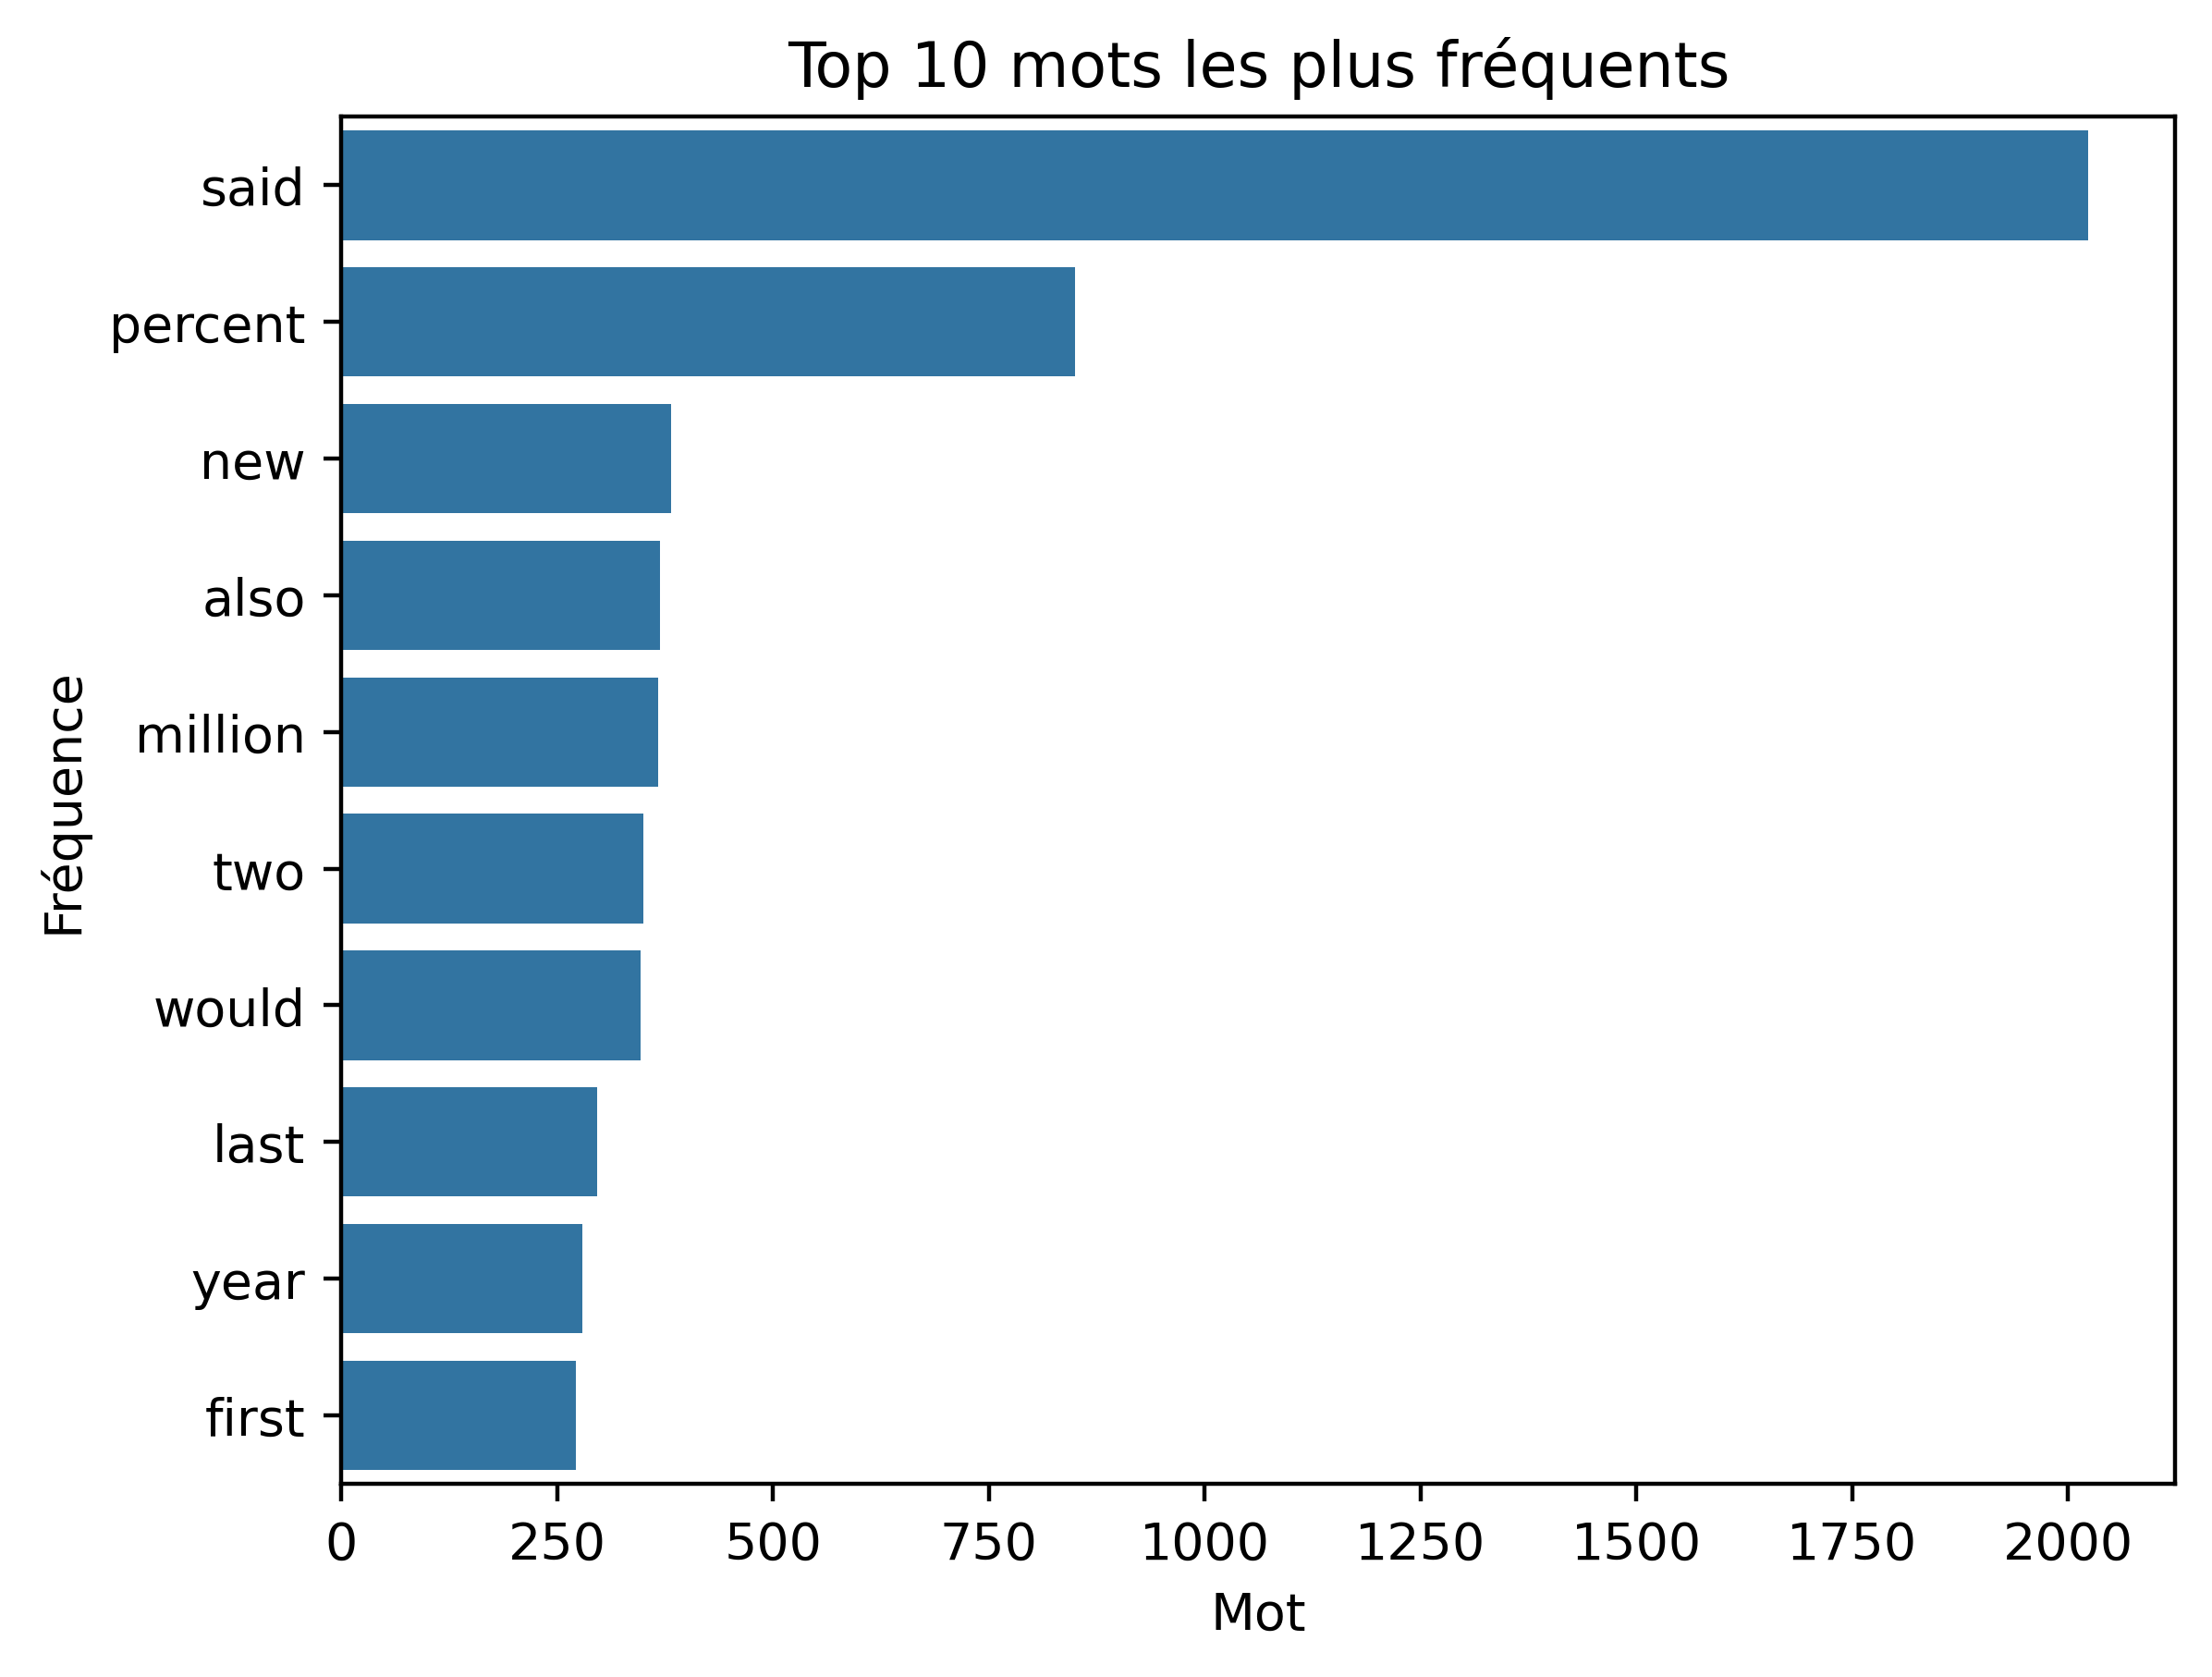

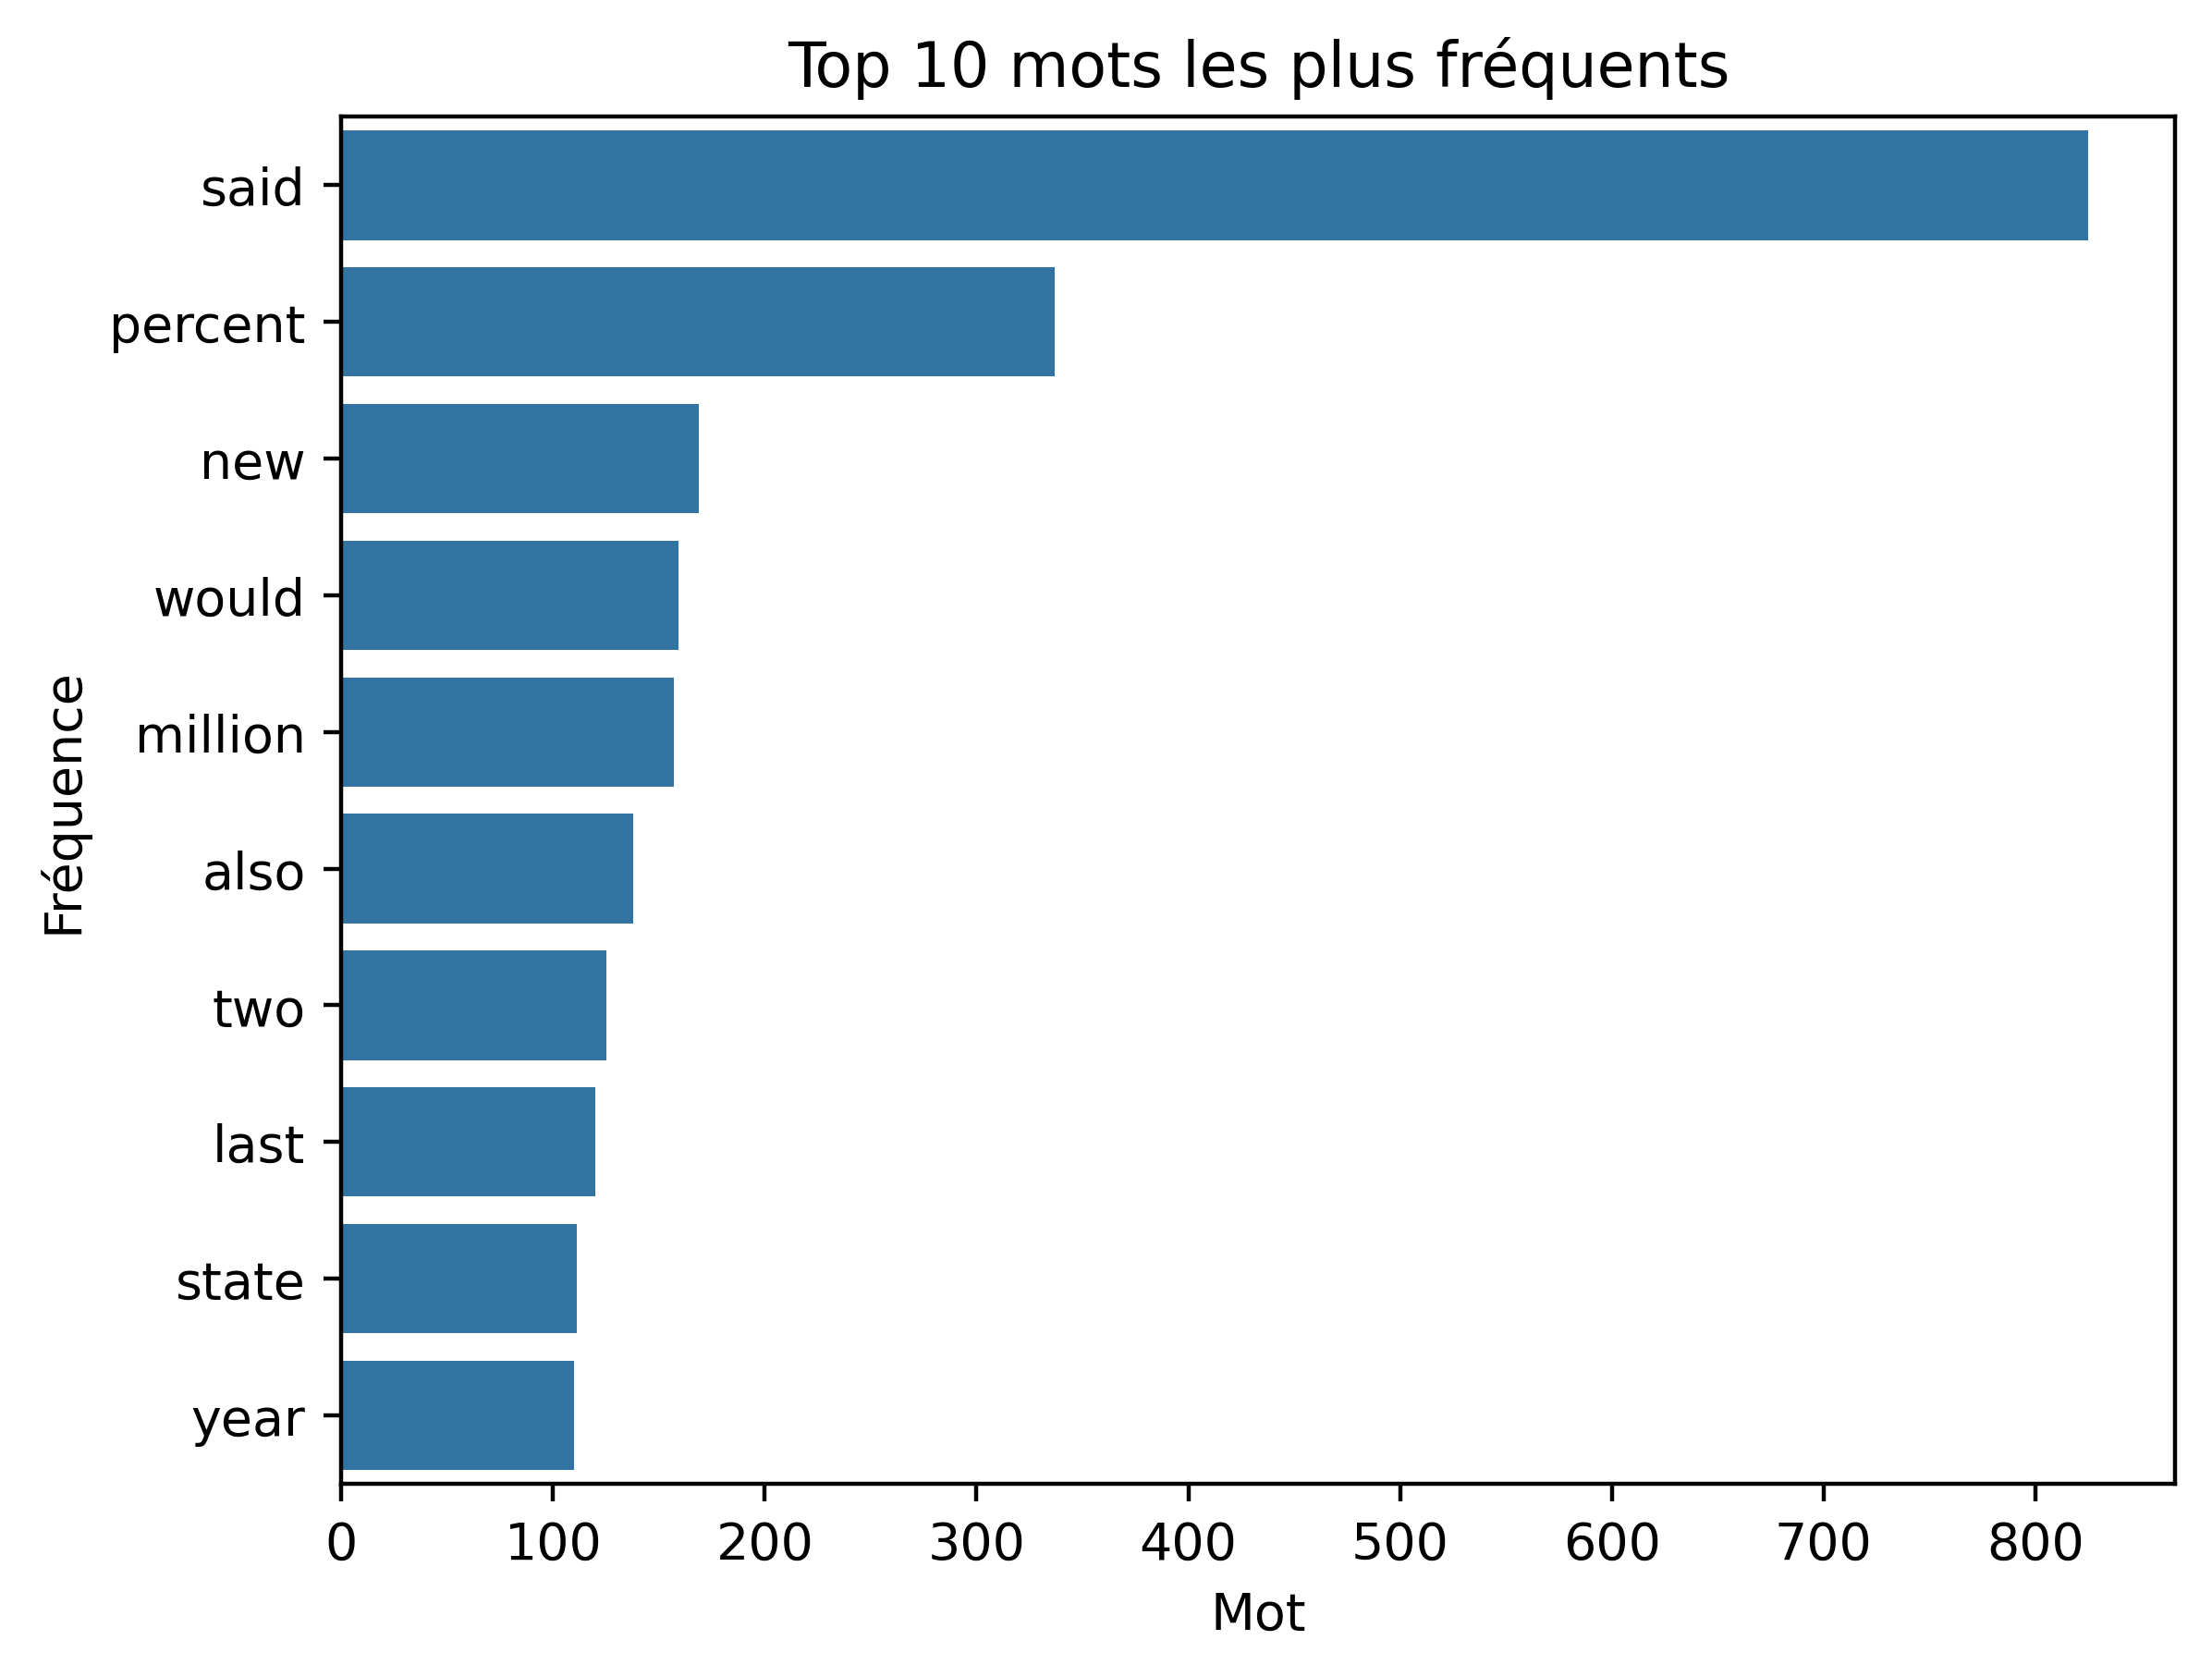

In [77]:
datasets = [(data_train, labels_train), (data_test, labels_test)]
for dataset, labels in datasets:
    # Créer un dataset pour les paraphrases et les non paraphrases
    dataset_similaire, dataset_assimilaire = [], []
    n = len(dataset)//2
    for i in range(n):
        if int(labels[i]) == 1:
            dataset_similaire.append(dataset[i])
            dataset_similaire.append(dataset[i + n])
        else:
            dataset_assimilaire.append(dataset[i])
            dataset_assimilaire.append(dataset[i + n])
    dataset_similaire, dataset_assimilaire = pd.Series(dataset_similaire), pd.Series(dataset_assimilaire)

    length_of_sentences(dataset_similaire, dataset_assimilaire, dataset)
    length_of_words(dataset_similaire, dataset_assimilaire, dataset)
    mean_length_of_words(dataset_similaire, dataset_assimilaire, dataset)
    frequence_of_stop_words(dataset)
    most_frequent_words(dataset)
    top_n_bigrams(dataset, 2)
    top_n_bigrams(dataset, 3)
    entity_frequencies(dataset)

In [ ]:
# nombre de phrases sémantiquement similaire vs pas similaire
# autour de 50% signifie balancé sinon débalancé
print("train:", sum(int(i) for i in labels_train) / len(labels_train) * 100)
print("test:", sum(int(i) for i in labels_test) / len(labels_test) * 100)

In [83]:
# Documentation pour les entities de spacy
for ent in ["PERSON", "NORP", "FAC", "ORG", "GPE", "LOC", "PRODUCT", "EVENT",
            "WORK_OF_ART", "LAW", "LANGUAGE", "DATE", "TIME", "PERCENT",
            "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]:
  print(ent, spacy.explain(ent))

PERSON People, including fictional
NORP Nationalities or religious or political groups
FAC Buildings, airports, highways, bridges, etc.
ORG Companies, agencies, institutions, etc.
GPE Countries, cities, states
LOC Non-GPE locations, mountain ranges, bodies of water
PRODUCT Objects, vehicles, foods, etc. (not services)
EVENT Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART Titles of books, songs, etc.
LAW Named documents made into laws.
LANGUAGE Any named language
DATE Absolute or relative dates or periods
TIME Times smaller than a day
PERCENT Percentage, including "%"
MONEY Monetary values, including unit
QUANTITY Measurements, as of weight or distance
ORDINAL "first", "second", etc.
CARDINAL Numerals that do not fall under another type
